# Deep Neural Network for Image Restoration ($35+25+20=80$ points)

As part of the lecture several methods have been presented that use deep neural networks to tackle some of the problems we came across when capturing and processing images.
Now it is your task to implement a deep neural network and train it for the task of image restoration, denoising in particular.

Neural networks can be understood as universal function approximators.
Here we want to find a function $y = f(\hat{x})$ that approximates the solution of the inverse problem of restoring the clean, original image $y$ from a corrupted image $\hat{x}$. We do this by optimzing the _parameters_ or _weights_ of a _convolutional neural network_, i.e. a graph with layers of convolutional filters. 
As we did for other methods of datafitting we do so by fitting the parameters to a set of measurements and observations, the dataset. This is called _training_ in the context of Neural Networks. In our supervised setting $y$ equals the original, uncorrupted image $x$ during training. 

## Prerequisite
For this task we use the [Pytorch](https://pytorch.org/) framework together with [Pytorch Lightning](https://www.pytorchlightning.ai/) which gives us a clean object oriented way of structuring the code. We prepared a **[Google Colab](https://colab.research.google.com/drive/1xuz0wXvPkw1QOOmE6PXVu0TGcJi4LWdN?usp=sharing) version** of this sheet so you can make use of a GPU independent of your own compute ressources. Please make a copy of the notebook and follow the instructions in Colab. If you don't want to use Google, you can also work locally using this notebook. 

In this case a couple of additional dependencies need to be added to your environment. Unfortunately, there is no easy and clean solution to install Pytorch with poetry. Please navigate to your exercise root folder, i.e. the directory where your `pyproject.toml` file is located and add the following lines to your `pyproject.toml` file:

```
urllib3 = "<2.0"
pytorch-lightning = "<2.0.0"
tensorboard = ">2.0"

torch = { url = "https://download.pytorch.org/whl/cu116/torch-1.13.1%2Bcu116-cp39-cp39-linux_x86_64.whl"}
torchvision = { url = "https://download.pytorch.org/whl/cu116/torchvision-0.14.1%2Bcu116-cp39-cp39-linux_x86_64.whl"}
```


Here we assume a Linux distribution with CUDA $\geq$ 11.6 installed. If you need a different configuration you can select the appropriate python wheels from [https://download.pytorch.org/whl/torch_stable.html](https://download.pytorch.org/whl/torch_stable.html) and replace the urls above. [https://pytorch.org/get-started/previous-versions/](https://pytorch.org/get-started/previous-versions/) gives you an overview of working configurations for Pytorch 1.x.

`poetry update`

Now reload your python kernel in the notebook. If you quit jupyter lab, start it again and reopen this notebook.

Run the following cell to check if we can import all required packages now. Depending on your iPython version you might get a deprecation warning. That's ok. In case something goes wrong, verify that your python kernel has really been restarted and all packages are installed, e.g. by inspecting your _Pipfile_ or running `poetry show`.

For visualization of the training process and model performance [TensorBoard](https://www.tensorflow.org/tensorboard?hl=en) is a popular tool. There is an add-on available for jupyter lab which simplifies usage a lot. An extension for this already comes with the jupyter lab installation. If you are working with a different IDE you probably need to run TensorBoard separately. You can find information on the procedure following the aforementioned link. Under the hood TensorBoard works as a webserver that processes your log files from the training process and serves a nice interactive website for visualization.

In [8]:
# Install all required packages.
%pip install ipympl pytorch-lightning torchvision tensorboard

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Load the Tensorboard notebook extension.
%load_ext tensorboard
%matplotlib widget
import os
from typing import Optional, Tuple

import imageio
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pytorch_lightning as pl
from skimage.metrics import peak_signal_noise_ratio
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm

from bsds500_dataset import BSDS500
from noise import add_gaussian_noise
print("Torch installed at version ", torch.__version__)
print("Lightning installed at version ", pl.__version__)
print("Torchvision installed at version ", torchvision.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Torch installed at version  2.3.1
Lightning installed at version  2.3.2
Torchvision installed at version  0.18.1


## Data
As you are probably aware, data is critical for Deep Learning. Here we use BSDS500, the [Berkley Image Segmentation Dataset](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html), which is the extended version of the BSDS200 that has been used in the provided paper by Mao et al. We included a copy of it in the 'dataset' directory. For your convenience, we also provide a dataset class which loads an image from the directory and performs some _data augmentation_. Data augmentation is used to increase the number of training examples from the limited number of input images as it introduces some random transforms on the data. Feel free to have a look into the [`bsds500_dataset.py`](bsds500_dataset.py) file to learn more about the data pipeline. The following cell shows examples of how to use the dataset class to load and visualize some datapoints.

In Pytorch all data is stored in so-called __Tensor__ objects. As a start, you can think of Tensors in Pytorch as Numpy arrays with additional functionality to store gradient information and enable GPU support. When working with RGB images, we usually deal with four dimensional tensors in deep learning. A _batch dimension_ [B] is added as the first dimension to our three dimensional images, essentially grouping a number of images into one example for a training iteration. Indexing can be done the same way as for Numpy arrays. Be aware, that Pytorch's convolutional layers expect a channel-first layout, which means that our images are of shape [C, H, W] here, where C is the number of channels, H and W the number of rows and columns, respectively. In the following example you can also see how to convert channel layouts.

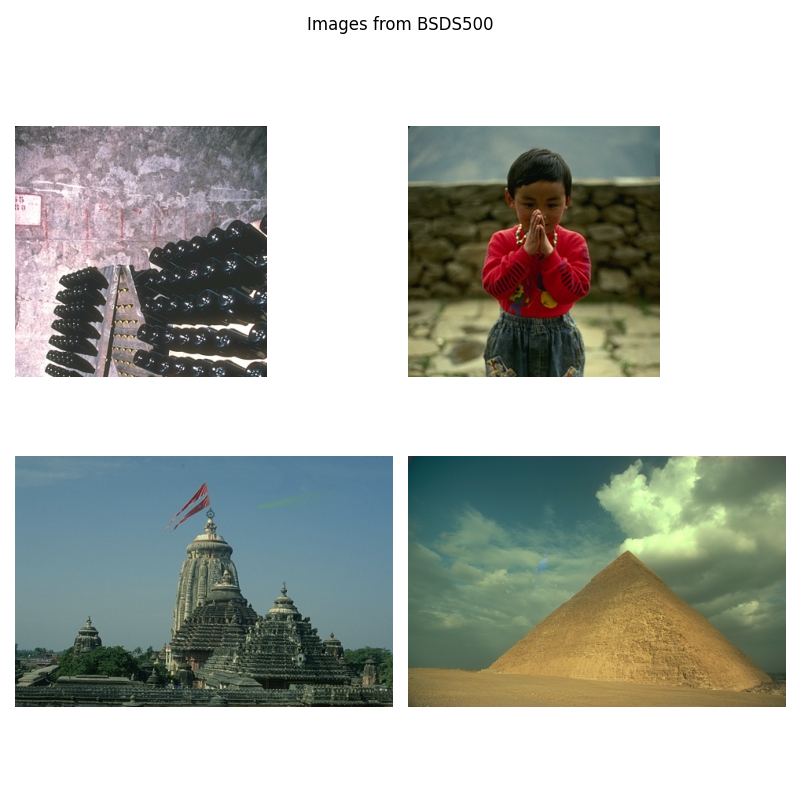

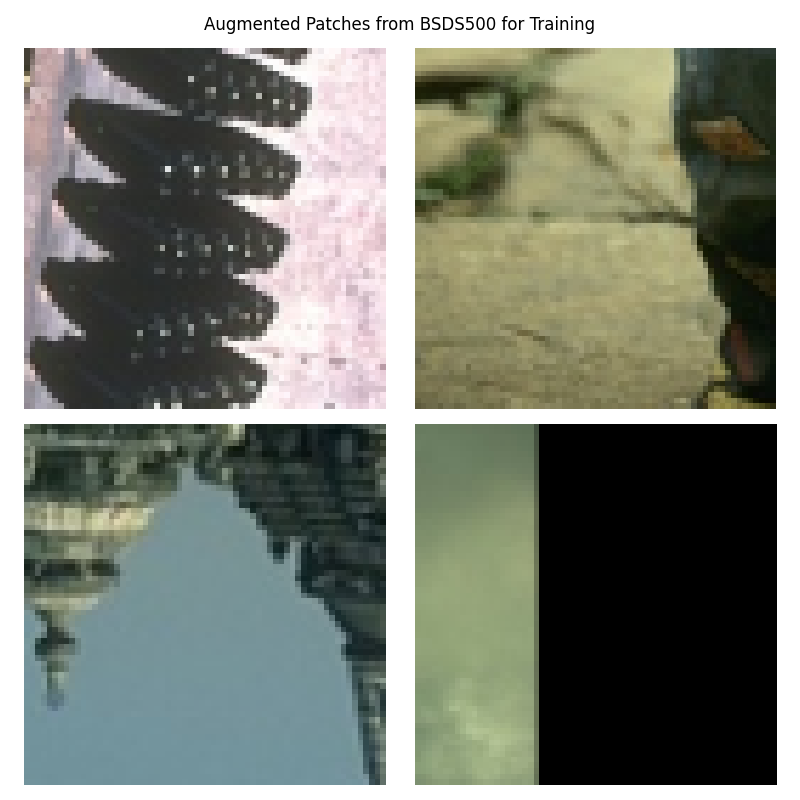

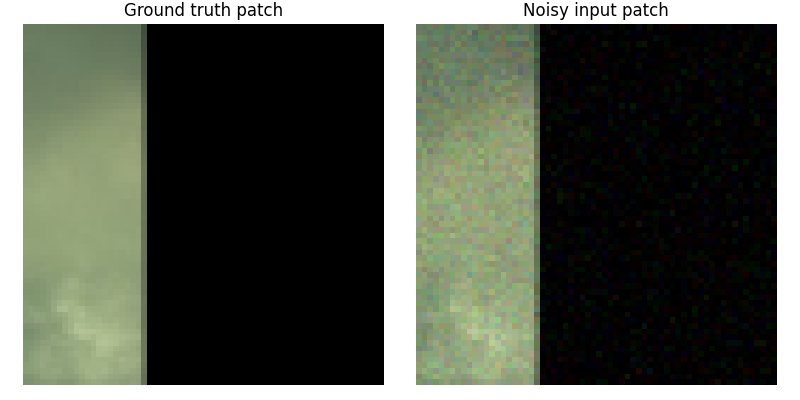

In [15]:
DATA_ROOT = os.path.join("dataset", "BSDS500", "images")
def test_data():
    """Perform a quick dataset test."""
    plain_dataset = BSDS500(os.path.join(DATA_ROOT, "train"))
    
    # Load some of the original images.
    plain_images = []
    for i in range(4):
        # Retrieve an image from the dataset.
        img = plain_dataset.__getitem__(i).cpu().numpy()
        # Prepare image for visualization.
        # Transpose to convert from [C, H, W] to [H, W, C].
        img = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
        plain_images.append(img)
    
    # Try the train dataset with the augmentation we would later use.
    augmented_images = []
    # Set up some transformations.
    # The data is converted to a torch tensor before the transforms are applied.
    # Therefore, we can use the torch.nn.Sequential object to define the sequence
    # of transforms.
    transforms = torch.nn.Sequential(
        # Random scale.
        torchvision.transforms.RandomAffine(
            degrees=0,
            scale=(0.5, 1.0),
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR
        ),
        # Randomly crop a 64 x 64 square patch.
        torchvision.transforms.RandomCrop(64),
        # Rotate or flip the image.
        torchvision.transforms.RandomHorizontalFlip(p=0.3),
        torchvision.transforms.RandomVerticalFlip(p=0.3),
    )
    # Create new dataset instance. Feed also the transforms object.
    train_dataset = BSDS500(os.path.join(DATA_ROOT, "train"), transforms)
    for i in range(4):
        # Retrieve an image from the dataset.
        img = train_dataset.__getitem__(i).cpu().numpy()
        # Prepare image for visualization.
        img = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
        augmented_images.append(img)
    
    # Plot images.
    fig2, axs2 = plt.subplots(2, 2, figsize=[8, 8], sharex="all", sharey="all")
    for i in range(2):
        for j in range(2):
            axs2[i][j].imshow(plain_images[i*2 + j])
            axs2[i][j].set_axis_off()
    fig2.suptitle("Images from BSDS500")
    fig2.tight_layout()
    # fig2.show()
    
    fig, axs = plt.subplots(2, 2, figsize=[8, 8], sharex="all", sharey="all")
    for i in range(2):
        for j in range(2):
            axs[i][j].imshow(augmented_images[i*2 + j])
            axs[i][j].set_axis_off()
    fig.suptitle("Augmented Patches from BSDS500 for Training")
    fig.tight_layout()
    # fig.show()
    
    # Patch with and without noise.
    example = augmented_images[-1].astype(np.float32) / 255
    noisy_example = add_gaussian_noise(example, sigma=0.03)
    
    fig3, ax3 = plt.subplots(1, 2, figsize=[8, 4])
    ax3[0].imshow(example)
    ax3[0].set_axis_off()
    ax3[0].set_title("Ground truth patch")
    ax3[1].imshow(noisy_example)
    ax3[1].set_axis_off()
    ax3[1].set_title("Noisy input patch")
    fig3.tight_layout()
    # fig3.show()
    
test_data()

## 1. Implementation ($35$ points)
### a) 
Take a look into the paper _Image Restoration Using Very Deep Convolutional Encoder-Decoder Networks with Symmetric Skip Connections_ by Mao et al. ([pdf](Mao_et_al.-2016-Image_Restoration_Using_Very_Deep_Convolutional_En.pdf)) and try to understand the network architecture they are using for the task of image restoration. A quick sketch on a piece of paper might help.
There is no need to submit anything here.

### b) ($10+10+10 = 30$)
Implement the network structure of the __Rednet__ described in the paper by completing the following model class. The relevant sections are marked with __Todo__.
Please implement a 10 layer version of the network (5 encoder + 5 decoder layers) using skip connections. If you like and you have a powerful computer or GPU available, feel free to increase the layer number to achieve the original configurations of _REDNET20_ and _REDNET30_ used with skip connections later.

* We structured the model into an encoder and decoder part.
* Start with setting up the layer objects in the `__init__` function for the encoder part. Add all blocks of your encoder and decoder to a _torch.nn.ModuleList_ which can later be worked with like a regular python list. Each block can be set up as a _torch.nn.Sequential_ module, grouping individual layers into a fixed sequence. Have a look into the Pytorch documentation to learn more about how the constructors of these modules work.
* Continue with the decoder. The term _deconvolution_ used in the paper can be a bit misleading and means _transposed convolution_ here.
* If you haven't already, add activation functions. There are different opinions on where to best put the activation function relative to a convolutional layer. If you use a different scheme than described in the paper please put in a comment explaining what you did. Depending on the scheme you might not have to put a second activation function after each skip connection.
* The `forward()` method is called for model evaluation. Call here the layers you set up in `__init__` in the correct order, i.e. feeding your network input into the first encoder block and the resulting feature map into the next block and so on... Here, also add the logic for the _skip connections_. For optimization there is also a `backward` operation which is actually computed for us by Pytorch's automatic differentiation module.


_Hints_: 
* Make sure the size of the feature maps stays constant between all layers. The convolutional layers have padding options for that, for example. 
* The pytorch `nn` module has implementations for all the layers we need. You just need to create an instances of the respective class for each layer. Example: `conv1 = torch.nn.Conv2d(in_channels, out_channels, 3)` creates a conv 2d layer with `out_channels` many _3x3x`in_channels`_ kernels. Use the [Pytorch documentation](https://pytorch.org/docs/stable/index.html) to find out about the attributes and inner workings of the different available layers. 
* You can use list comprehensions or other loops to construct the layer lists but it might be easier to write it down plainly with some code duplication first. 
* To debug network architectures adding prints of tensor shapes often is a reasonable first step.

### c) (5)
To be able to train your model you'll need a loss function. Implement the (static) method `mse_loss(ground_truth, prediction)` which computes the __loss__ as the mean squared error between the prediction by the network and ground truth $y$:
$$\mathcal{L} = ||f(\hat{x}) - y||^2$$
Call it in the `train_step` and `validation_step` to compute the loss.

In [32]:
class RedNet(pl.LightningModule):
    """Deep Convolutional Neural Network for image restoration.
    
    Inspired by Mao et al. 2016.
    """
    def __init__(
        self,
        learning_rate: float = 1e-3,
        img_channels: int = 3,
        channels: int = 64,
        noise_sigma: Tuple[float, float] = (1e-4, 1e-1)
    ):
        """Init Rednet.
        
        Args:
            learning_rate: 
                Learning rate to be set in the Optimizer.
            img_channels:
                Channels of the input and output images. 3 are the
                default, assuming RGB images.
            channels:
                Channels of the convolutional layers. This is the
                same for all layers in the default configuration.       
        """
        super().__init__()
        
        # Set up hyperparameters.
        self.learning_rate = learning_rate
        self.channels = channels
        self.img_channels = img_channels
        self.noise_sigma = noise_sigma
        
        # Set up layers of the network architecture.
        # We divide the architecture into encoder and decoder part which
        # consist of the convolutional and transposed convolutional layers, respectively.
        
        # Todo: Set up the encoder as a ModuleList.
        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(img_channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.Conv2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
        ])
        
        # Todo: Set up the decoder as a ModuleList.
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.ReLU(),
            nn.Sequential(
                nn.ConvTranspose2d(channels, channels, 3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(channels, channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.ReLU(),
            nn.Sequential(
                nn.ConvTranspose2d(channels, channels, 3, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(channels, img_channels, 3, padding=1),
                nn.ReLU(),
            ),
            nn.ReLU(),
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward defines the prediction/inference actions.
        
        Args:
            x:
                Input to our network architecture of shape [B, C, H, W].
        
        Returns:
            Prediction of the network as torch Tensor of shape [B, C, H, W].
        
        """
        # Todo: Call the network blocks here and add the skip connections.
        # Follow Fig. 1 in Mao et al. for the skip connection layout here.
        # Return the output of the last layer as prediction.

        # Encoder 
        skip_outputs = [x]
        for i, module in enumerate(self.encoder):
            x = module(x)
            
            # Store skip connection output every other layer
            if i % 2 == 1:
                skip_outputs.append(x)
            
        # Decoder
        for i, module in enumerate(self.decoder):
            # Apply skip connection every other layer
            if i % 2 == 1:
                x = x + skip_outputs.pop()
                
            x = module(x)
        
        return x

    def configure_optimizers(self):
        """Set up the optimizer.
        
        We use ADAM here, a variant of a stochastic gradient descent
        algorithm. It is widely used for training of deep neural networks.
        The original paper can be found at http://arxiv.org/abs/1412.6980.
        
        Returns:
            Optimizer object configured to update all relevant model parameters.
        
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def add_image_noise(
        self,
        img_batch: torch.Tensor,
        sigma: Optional[Tuple[float, float]] = (5e-4, 5e-3)
    ) -> torch.Tensor:
        """Add gaussian noise with a random sigma.
        
        Args:
            img_batch:
                Input images to add noise to of shape [B, C, H, W].
            sigma:
                Range of sigmas to sample the standard deviation from,
                as a Tuple (min, max). Mean of the gaussian distribution
                is zero.
        
        Returns:
            Noisy images as torch tensor of the same shape as input.
        """
        sigmas = torch.rand(img_batch.shape, device=self.device)
        sigmas = sigmas * (sigma[1] - sigma[0]) + sigma[0]
        
        return (img_batch + torch.normal(mean=0.0, std=sigmas)).clip(0, 1)
    
    def mse_loss(self, img1, img2):
        """Compute MSE between two images
        
        Images are expected to be in range 0-1.
        
        Args:
            img1: First image.
            img2: Second image.
            
        Returns:
            MSE as scalar Tensor.
        """
        return torch.mean((img1 - img2) ** 2)

    def psnr(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        """Compute PSNR between two images. 
        
        Images are expected to be in range 0-1.
        
        Args:
            img1: First image.
            img2: Second image.
            
        Returns:
            PSNR as scalar Tensor.
        
        """
        try:
            mse = self.mse_loss(img1, img2)
        except AttributeError as e:
            print(e, " You probably still want to implement mse_loss().")

        return - 10 * torch.log10(mse)
    
    def training_step(self, train_batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        """training_step defines the train loop.
        
        Args:
            train_batch:
                Input batch of images.
            batch_idx:
                Index of the current batch.
        
        Returns:
            Loss to be optimized as scalar tensor.
        """
        # From the dataloader we get the ground truth x.
        x = train_batch
        # Add noise to create our training data pair.
        # We shift and scale the value range so it is in [-1, 1], centered around 0.
        x_hat = self.add_image_noise(x, self.noise_sigma) * 2 - 1
        # Call the forward pass.
        y_hat = self.forward(x_hat)
        # Shift back to [0, 1] range.
        y_hat = (y_hat + 1) * 0.5
        
        # Todo: Compute the Loss.
        loss = self.mse_loss(x, y_hat)

        # Log train loss.
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch: torch.Tensor, batch_idx: int) -> None:
        """validation_step defines the loop for validation steps.
        
        Args:
            val_batch:
                Input batch of images.
            batch_idx:
                Index of the current batch.
        """
        x = val_batch
        # Add noise to create our validation data pair.
        x_hat = self.add_image_noise(x, sigma=(1e-3, 1e-1)) * 2 - 1
        # Call the forward pass.
        # And shift back to 0 to 1 range.
        y_hat = (self.forward(x_hat) + 1) * 0.5
        
        # Todo: Compute the Loss.
        loss = self.mse_loss(x, y_hat)

        # Log val loss.
        self.log("val_loss", loss)
        # Log PSNR.
        psnr = self.psnr(x, y_hat)
        self.log("val_psnr", psnr)
        
        # Also log some images to judge training progress.
        if batch_idx < 1:
            # Only do this for the first batch.
            for b in range(y_hat.shape[0]):
                if b >= 3:
                    continue
                viz = torch.cat(
                    [x[b], y_hat[b]],
                    axis=-1,
                )
                viz = torch.clamp(viz, 0, 1)
                self.logger.experiment.add_image(
                    "gt_vs_pred_{}_{}".format(batch_idx, b), viz, self.global_step,
                )


## 2. Training ($25$ points)

### a) (15)
Run the following cell to train your model. We set rather low default values for the number of epochs.
To get better results increase the number of epochs (= iterations) later. Note down the achieved loss and the number of steps in a markdown cell.
Upload the _.ckpt_ - file of your best training run with your submission. Please delete the data of all other versions from the `train_log`directory.


In [30]:
# Set up parameters.

# The log dir will contain the saved model parameters as well as meta data like the loss value
# written out during model training and validation (as .ckpt files).
log_dir = os.path.join("train_log", "denoise_rednet")
os.makedirs(log_dir, exist_ok=True)
# Batch size, how many images to group into one example.
batch_size = 16
# Number of channels in the CNN.
nn_channels = 128
# Input channels of your images.
img_channels = 3
# Patch size of your input data. On weak machines you may change this to 32.
patch_size = 64
# Worker threads for the data generation. Feel free
# to tune this value.
worker_threads = multiprocessing.cpu_count() // 2
# Number of epochs (= runs through the dataset) during the training.
# This determines the number of iterations of your training loop.
# Todo: Increase this when your implementation runs.
epochs = 500
# Learning rate is related to the step size in gradient descent.
learning_rate = 1e-3
# Range of sigma values (min, max) to sample the noise during training.
noise_sigma = (1e-3, 1.5e-1)

# Set up data.
train_transforms = torch.nn.Sequential(
    # Random scale.
    torchvision.transforms.RandomAffine(
        degrees=0,
        scale=(0.5, 1.0),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR
    ),
    # Randomly crop a 64 x 64 square patch.
    torchvision.transforms.RandomCrop(patch_size),
    # Rotate or flip the image.
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
    torchvision.transforms.RandomVerticalFlip(p=0.3),
)
train_dataset = BSDS500(os.path.join(DATA_ROOT, "train"), train_transforms)

# For our validation set we don't want to have randomness to be able
# to compare along epochs.
val_transforms = torch.nn.Sequential(
    # Scale.
    torchvision.transforms.RandomAffine(
        degrees=0,
        scale=(0.5, 0.5),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR
    ),
    # Crop the image.
    torchvision.transforms.CenterCrop(patch_size),
)
val_dataset = BSDS500(os.path.join(DATA_ROOT, "val"), val_transforms)

# Set up dataloaders. These objects use multiple copies of our datasets via
# python's multiprocessing to generate batches of images.
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=worker_threads,
    pin_memory=True,
    shuffle=True,
    drop_last=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=worker_threads,
    pin_memory=True,
    shuffle=False,
    drop_last=True,
)

# Dataloader self test.
# This should run without any exceptions thrown.
print("Dataset length: ", len(train_loader))
train_data_iter = iter(train_loader)
for i in tqdm(train_data_iter):
    next(train_data_iter)
val_data_iter = iter(val_loader)
for i in tqdm(val_data_iter):
    next(val_data_iter)

Dataset length:  12



 50%|██████████████████████████████████████████████████▌                                                  | 6/12 [00:27<00:27,  4.52s/it]

 50%|███████████████████████████████████████████████████                                                   | 3/6 [00:27<00:27,  9.10s/it]


In [ ]:
# Set up model.
model = RedNet(
    learning_rate = learning_rate,
    img_channels = img_channels,
    channels = nn_channels,
    noise_sigma = noise_sigma
)

print("Model ready:")
print(model)

# Set up checkpoint callback.
# We always keep the two best checkpoints according to the validation loss.
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    filename="checkpoint-{epoch:03d}-{val_loss:.3f}",
    save_top_k=2,
    mode="min",
)

# Set up Pytorch-Lightning's trainer object.
trainer = pl.Trainer(
    # gpus=0 if torch.cuda.device_count() < 1 else 1,
    max_epochs=epochs,
    limit_val_batches=4,
    check_val_every_n_epoch=2,
    default_root_dir=log_dir,
    callbacks=[checkpoint_callback],
    log_every_n_steps=len(train_loader)
)
# Start training.
trainer.fit(model, train_loader, val_loader)
    

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | ModuleList | 593 K  | train
1 | decoder | ModuleList | 593 K  | train
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.751     Total estimated model params size (MB)


Model ready:
RedNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1-4): 4 x Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (decoder): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): ReLU()
    (2): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): ReLU()
    (4): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (5): ReLU()
  )
)


Sanity Checking: |                                                                                            …

/Users/henk/miniconda3/envs/cph/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x16b6f8430>
Traceback (most recent call last):
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/henk/miniconda3/envs/cph/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._se

Validation: |                                                                                                 …

### b)
Have a look at the visualization of the training by completing and running the following cell to start Tensorboard. Keep in mind, the following command will only work in jupyter lab.

Explore the scalar values and image examples we logged during the training. You should see the training loss and validation loss go down over time. The images might still look a bit blurry or noisy after 100 epochs. To achieve better results, increase the number of epochs to a larger number (not mandatory for passing the exercise). An expected result after 500 epochs of training looks like the following.

_Hint_: Once your TensorBoard is running you can rerun the cell above for the training and get real-time results by using the refresh button on the top right in the TensorBoard.

In [ ]:
# Todo: Set the path to your log_dir. 
# It is enough to have it point to your "lightning_logs" subdirectory.
%tensorboard --logdir train_log/denoise_rednet/lightning_logs/

### c) (10)
Test the model. Now, let's see how the trained model performs on unseen, full images. In the following cell we will load images from the test set, not used so far, and feed them to the trained model. Therefore, we need to load a checkpoint for the model parameters from our _train_log_. Code to plot some of the examples is already given.

_Hint:_ More information on how saving and loading of model weights works with Pytorch Lightning can be found [here](https://pytorch-lightning.readthedocs.io/en/stable/common/weights_loading.html).

In [ ]:
def denoising_test(dataset: torch.utils.data.Dataset, model: pl.LightningModule, n: int = 4):
    """Test a trained model by visualizing some denoising examples.
    
    Args:
        dataset:
            Test dataset.
        model:
            Instance of a LightningModule with the relevant parameters loaded.
        n:
            Number of examples to plot.
    
    Raises:
        TypeError: If model or dataset is None.
    """
    if dataset is None or model is None:
        raise TypeError("Dataset and model need to be provided for testing.")
    n = min(n, len(dataset))
    gt_images = []
    noisy_images = []
    denoised_images = []
    psnr = 0
    for i in tqdm(range(n)):
        img = dataset.__getitem__(i)
        gt_img = img.cpu().numpy().transpose(1, 2, 0)
        gt_images.append(gt_img)
        # Add noise.
        sigmas = torch.ones(img.shape, device=img.device) * 0.1
        noisy_img = (img + torch.normal(mean=0.0, std=sigmas)).clip(0, 1)
        noisy_images.append(noisy_img.cpu().numpy().transpose(1, 2, 0))
        # Call your model here and add the result to the denoised_images list.
        # Shift the value ranges like it has been done in the validation_step.
        denoised_img = (
            (model(noisy_img.unsqueeze(0) * 2 - 1)[0] + 1) * 0.5
        )
        denoised_img = denoised_img.detach().cpu().numpy().transpose(1, 2, 0)
        denoised_images.append(np.clip(denoised_img, 0, 1))
        # Compute psnr.
        psnr += peak_signal_noise_ratio(gt_img, denoised_img)
    
    print("Mean PSNR on test set: {:02.3f} dB".format(psnr / n))
    
    # Plot the results.
    fig, ax = plt.subplots(n, 3, figsize=[10, 4 * n], sharex="row", sharey="row")
    
    for i in range(n):
        ax[i][0].imshow(noisy_images[i])
        ax[i][1].imshow(denoised_images[i])
        ax[i][2].imshow(gt_images[i])
        for j in range(3):
            ax[i][j].set_axis_off()
        if i == 0:
            ax[i][0].set_title("Noisy image")
            ax[i][1].set_title("Denoised image")
            ax[i][2].set_title("Ground truth image")
    fig.suptitle("Test Examples")
    fig.tight_layout()
    fig.show()
    

# Todo: Create a dataset for testing that uses the images from the test subdirectory inside the BSDS500 folder.
test_dataset = None

# Todo: Create an instance of RedNet and initialize a trained model using "load_from_checkpoint(PATH)".
# Hint: There are multiple ways to do this. You might need to match the parameters of your training in the constructor depending on
# how you do it.
trained_rednet = None

if trained_rednet:
    trained_rednet.eval()

# Call the test function.
denoising_test(test_dataset, trained_rednet)


## 3. Super-Resolution
### a) (10)
RedNet has also been used for other image reconstruction tasks like super-resolution, for example. Let's try this ourselves for the task of x2 super resolution (scaling an image to double the size in height and width). Implement new `raining_step()` and `validation_step()` functions for the class `SrRedNet` which inherits from your RedNet. Use bilinear interpolation for any scaling operation.

*Hint:* You can find useful utility functions in the torchvision package.

In [ ]:
import torchvision.transforms.functional as ttf

class SrRedNet(RedNet):
    def training_step(self, train_batch: torch.Tensor, batch_idx: int) -> torch.Tensor:
        """training_step defines the train loop.

        Args:
            train_batch:
                Input batch of images.
            batch_idx:
                Index of the current batch.

        Returns:
            Loss to be optimized as scalar tensor.
        """
        # Todo
        raise NotImplementedError("Training step for super-resolution still to be implemented.")

    def validation_step(self, val_batch: torch.Tensor, batch_idx: int) -> None:
        """validation_step defines the loop for validation steps.

        Args:
            val_batch:
                Input batch of images.
            batch_idx:
                Index of the current batch.
        """
        # Todo
        raise NotImplementedError("Validation step for super-resolution still to be implemented.")

### b) (5 + 5 = 10)
Copy the code from above for training and testing and make the necessary adjustments.
Then run a training and see if you get the expected results from the test run.
Use a patch size of at least 64x64 pixels as your target resolution here.

*Hint:* You can use the tensorboard from above, too. You just need to adjust the path to the log files accordingly.

In [3]:
# Todo: Add code for training and testing.

# Todo: Run the training and testing.